β1 = 0.010000
β2 = 0.010000
σ  = 0.047619
γ  = 0.200000
μ  = 0.050000
δ  = 0.100000
η  = 0.100000
ε  = 0.001000
κ  = 50.000002


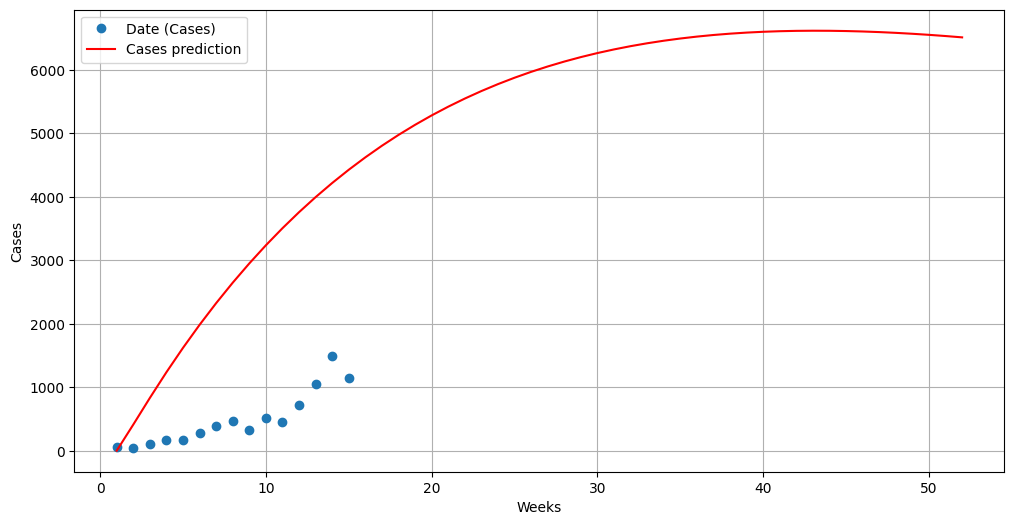

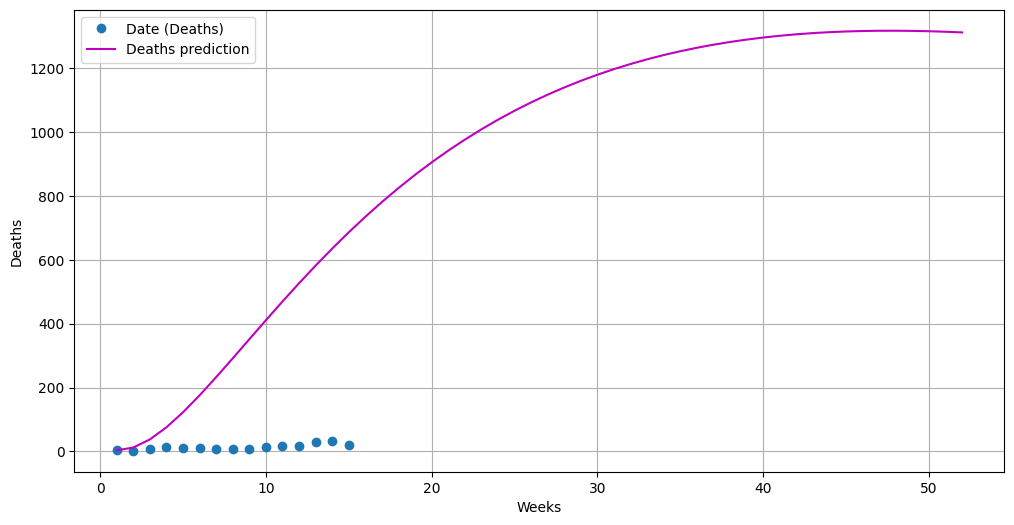

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# ==============================
# بيانات أسبوعية (حالات ووفيات)
# ==============================
weeks = np.arange(1, 16)
cases_data = np.array([
    64, 52, 101, 168, 175,
    279, 393, 472, 324, 517,
    460, 722, 1059, 1495, 1140
], dtype=float)
deaths_data = np.array([
    4, 2, 7, 14, 11,
    12, 8, 7, 8, 13,
    18, 18, 30, 32, 21
], dtype=float)

# ==============================
# النموذج SEIR-C مع C لوجستية
# ==============================
def seirc_model(t, y, N, beta1, beta2, sigma, gamma, mu, delta, eta, epsilon, kappa):
    S, E, I, R, C = y
    dS = -beta1 * S * I / N - beta2 * S * C / (C + 1)
    dE = beta1 * S * I / N + beta2 * S * C / (C + 1) - sigma * E
    dI = sigma * E - gamma * I - mu * I
    dR = gamma * I
    # معادلة لوجستية للبكتيريا
    dC = eta * I * (1 - C/kappa) + epsilon * C - delta * C
    return [dS, dE, dI, dR, dC]

# ==============================
# محاكاة النموذج
# ==============================
def simulate_seirc(weeks_arr, N, beta1, beta2, sigma, gamma, mu, delta, eta, epsilon, kappa):
    I0 = cases_data[0]
    E0 = I0 // 2
    S0 = N - I0 - E0
    R0 = 0
    C0 = 5
    y0 = [S0, E0, I0, R0, C0]

    t_eval = weeks_arr  # الحساب بالأسابيع مباشرة
    t_span = (t_eval[0], t_eval[-1])

    sol = solve_ivp(seirc_model, t_span, y0,
                    args=(N, beta1, beta2, sigma, gamma, mu, delta, eta, epsilon, kappa),
                    t_eval=t_eval, rtol=1e-6, atol=1e-8, method="LSODA")

    if not sol.success:
        raise RuntimeError("ODE solver failed")

    S_vals, E_vals, I_vals, R_vals, C_vals = sol.y
    weekly_cases = sigma * E_vals
    weekly_deaths = mu * I_vals
    return weekly_cases, weekly_deaths, I_vals, R_vals, C_vals

# ==============================
# دالة الملاءمة
# ==============================
def fit_func(weeks_arr, beta1, beta2, sigma, gamma, mu, delta, eta, epsilon, kappa):
    N = 1_000_000
    try:
        pred_cases, _, _, _, _ = simulate_seirc(
            weeks_arr, N, beta1, beta2, sigma, gamma, mu, delta, eta, epsilon, kappa
        )
    except RuntimeError:
        pred_cases = np.full_like(weeks_arr, np.nan)
    return pred_cases

# ==============================
# تقدير المعاملات
# ==============================
p0 = [0.2, 0.1, 1/10, 1/14, 0.02, 0.05, 0.5, 0.01, 200]  # قيم ابتدائية
lower_bounds = [0.01, 0.01, 1/21, 1/30, 0.001, 0.001, 0.1, 0.001, 50]
upper_bounds = [0.5, 0.5, 1/3, 1/5, 0.05, 0.1, 2, 0.05, 500]

params, _ = curve_fit(fit_func, weeks, cases_data,
                      p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=20000)

beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit, epsilon_fit, kappa_fit = params

print(f"β1 = {beta1_fit:.6f}")
print(f"β2 = {beta2_fit:.6f}")
print(f"σ  = {sigma_fit:.6f}")
print(f"γ  = {gamma_fit:.6f}")
print(f"μ  = {mu_fit:.6f}")
print(f"δ  = {delta_fit:.6f}")
print(f"η  = {eta_fit:.6f}")
print(f"ε  = {epsilon_fit:.6f}")
print(f"κ  = {kappa_fit:.6f}")

# ==============================
# تشغيل النموذج لسنة كاملة (52 أسبوع)
# ==============================
weeks_year = np.arange(1, 53)
pred_cases, pred_deaths, I_pred, R_pred, C_pred = simulate_seirc(
    weeks_year, 1_000_000, *params
)

# ==============================
# الرسوم البيانية
# ==============================
plt.figure(figsize=(12,6))
plt.plot(weeks, cases_data, "o", label="Date (Cases)")
plt.plot(weeks_year, pred_cases, "-r", label="Cases prediction")
plt.xlabel("Weeks")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(weeks, deaths_data, "o", label="Date (Deaths)")
plt.plot(weeks_year, pred_deaths, "-m", label="Deaths prediction")
plt.xlabel("Weeks")
plt.ylabel("Deaths")
plt.legend()
plt.grid(True)
plt.show()

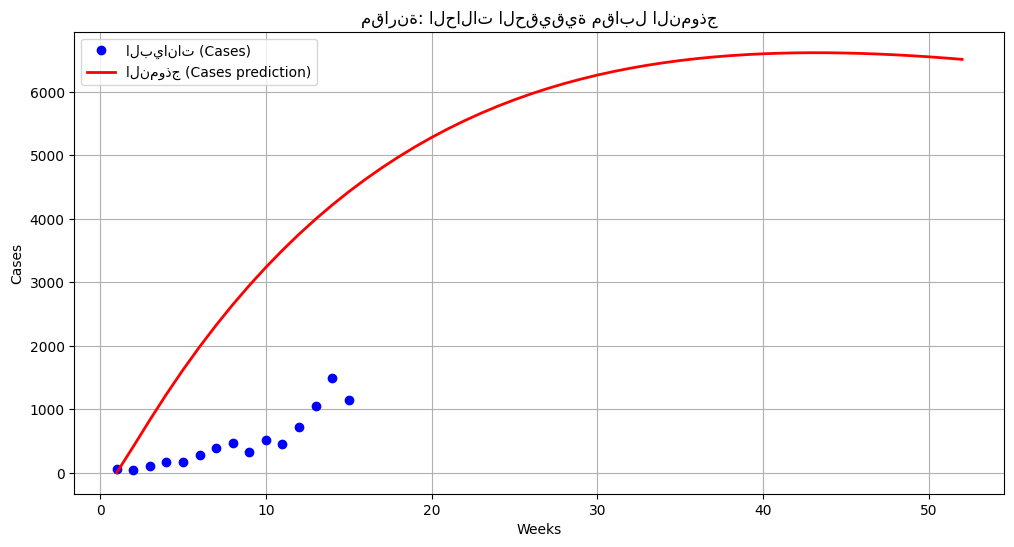

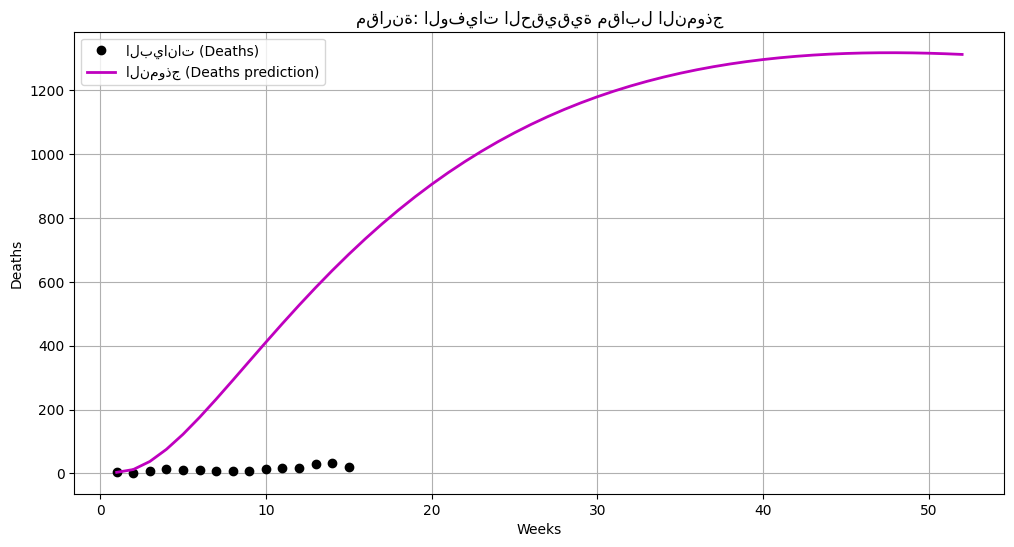

In [11]:
# ==============================
# مقارنة البيانات بالنموذج
# ==============================

plt.figure(figsize=(12,6))
plt.plot(weeks, cases_data, "o", color="blue", label="البيانات (Cases)")
plt.plot(weeks_year, pred_cases, "-r", linewidth=2, label="النموذج (Cases prediction)")
plt.xlabel("Weeks")
plt.ylabel("Cases")
plt.title("مقارنة: الحالات الحقيقية مقابل النموذج")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(weeks, deaths_data, "o", color="black", label="البيانات (Deaths)")
plt.plot(weeks_year, pred_deaths, "-m", linewidth=2, label="النموذج (Deaths prediction)")
plt.xlabel("Weeks")
plt.ylabel("Deaths")
plt.title("مقارنة: الوفيات الحقيقية مقابل النموذج")
plt.legend()
plt.grid(True)
plt.show()